# Deep Learning – Assignment 1: Single-Word Audio Classification 

## Library

In [36]:
!nvidia-smi

Thu Apr 17 14:08:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.42                 Driver Version: 572.42         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P8             13W /   75W |     109MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [37]:
import os

import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [38]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Extract Audio

In [39]:
# Dataset Class
class AudioDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = []
        self.labels = []
        self.label_map = {}

        # Traverse through the dataset and add samples and labels
        for idx, label in enumerate(sorted(os.listdir(root_dir))):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                self.label_map[idx] = label
                for file in os.listdir(label_path):
                    if file.endswith(".wav"):
                        self.samples.append(os.path.join(label_path, file))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path = self.samples[idx]
        label = self.labels[idx]
        y, sr = librosa.load(file_path, sr=None)

        # Extract audio features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=256)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

        # Combine features and normalize
        feature = np.hstack([
            np.mean(mfcc.T, axis=0),
            np.mean(chroma.T, axis=0),
            np.mean(spectral_contrast.T, axis=0),
            np.mean(tonnetz.T, axis=0)
        ])
        feature = (feature - np.mean(feature)) / (np.std(feature) + 1e-8)  # Normalize
        return torch.tensor(feature, dtype=torch.float32), label

In [40]:
train_dataset = AudioDataset("data/Training")
test_dataset = AudioDataset("data/Testing")

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Training


In [41]:
class AudioFNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AudioFNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [42]:
input_size = 13
num_classes = len(train_dataset.label_map)
model = AudioFNN(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3) 



In [43]:
# from torchsummary import summary

# summary(model, input_size=(1, 28, 28))

In [44]:
# Train in one epoch function
def train_one_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_correct = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        train_correct += torch.sum(predictions == labels.data)

    return train_loss / len(train_loader.dataset), train_correct.double() / len(train_loader.dataset) # type: ignore

# Validation function
def validate(model, val_loader, loss_fn, device):
    model.eval()
    val_loss, val_correct = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            val_correct += torch.sum(predictions == labels.data)

    return val_loss / len(val_loader.dataset), val_correct.double() / len(val_loader.dataset) # type: ignore

# Training and validation loop with timing
def train_and_validate(model, train_loader, val_loader, loss_fn, optimizer, epochs, device='cuda'):
    model.to(device)
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

    for epoch in tqdm(range(epochs), desc="Training Progress", leave=True):
        epoch_start_time = time.time()

        train_loss, train_accuracy = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_accuracy = validate(model, val_loader, loss_fn, device)
        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy.item())
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy.item())

        epoch_end_time = time.time()

        tqdm.write(f'Epoch {epoch+1}/{epochs}: Train loss: {train_loss:.4f}, Train accuracy: {train_accuracy:.4f}, '
                   f'Val loss: {val_loss:.4f}, Val accuracy: {val_accuracy:.4f}, '
                   f'Time: {(epoch_end_time - epoch_start_time):.2f}s')

    return model, history


In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, history = train_and_validate(model, train_loader, test_loader, criterion, optimizer, epochs=30, device=device)

Training Progress:   0%|          | 0/30 [00:00<?, ?it/s]c:\IIUM\AI Note IIUM\venv\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=491
  warnings.warn(
c:\IIUM\AI Note IIUM\venv\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=246
  warnings.warn(
c:\IIUM\AI Note IIUM\venv\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=416
  warnings.warn(
c:\IIUM\AI Note IIUM\venv\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=208
  warnings.warn(
c:\IIUM\AI Note IIUM\venv\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=448
  warnings.warn(
c:\IIUM\AI Note IIUM\venv\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=224
  warnings.w

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x38 and 13x128)

## Result


In [ ]:
model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().tolist())
        y_pred.extend(predicted.cpu().tolist())

print(accuracy_score(y_true, y_pred))

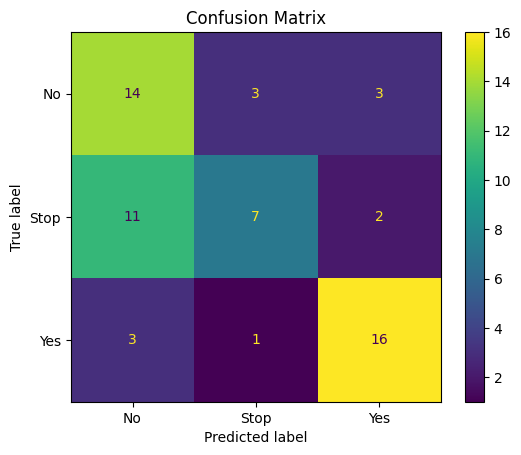

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=[train_dataset.label_map[i] for i in range(num_classes)]).plot()
plt.title("Confusion Matrix")
plt.show()

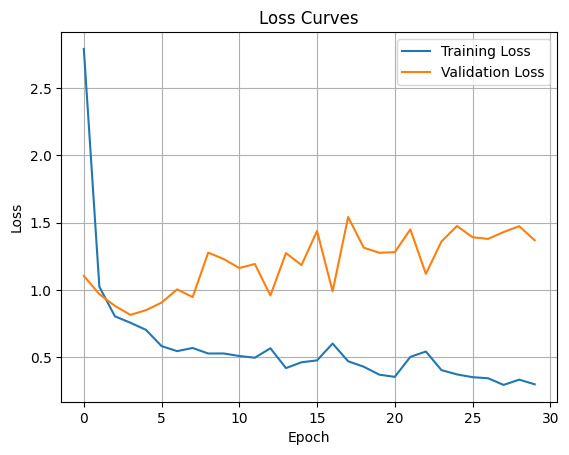

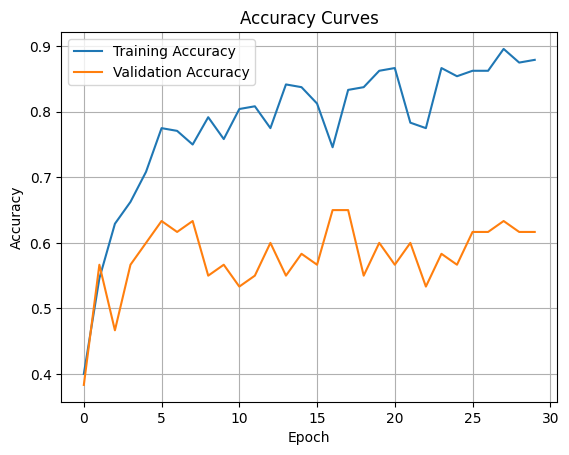

In [ ]:
plt.figure()
plt.plot(history['train_loss'], label="Training Loss")
plt.plot(history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history['train_accuracy'], label="Training Accuracy")
plt.plot(history['val_accuracy'], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.grid(True)
plt.show()